In [1]:
from matplotlib import image
import matplotlib.pyplot as plt
import numpy as np
import torch

%load_ext autoreload
%autoreload 2

from IPython.display import clear_output 
clear_output(wait = True)
import sys 
sys.path.append('..')
from models import LocationScaleFlow, SoftmaxWeight, SoftmaxWeightOver,DIFDensityEstimator, MixedModelDensityEstimator, RealNVPDensityEstimatorLayer, MultivariateNormalReference, EMDensityEstimator
from utils.color_visual import *

(256, 197, 3)


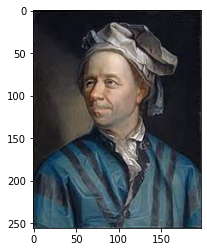

In [2]:
rgb = image.imread("euler.jpg")
plt.imshow(rgb)
print(rgb.shape)

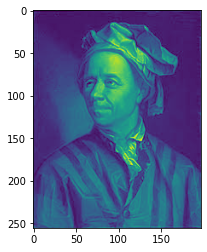

In [3]:
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])
grey = torch.tensor(rgb2gray(rgb))
plt.imshow(grey)

<ipython-input-4-74de8655d56d>:7: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  target_samples = torch.cat([(categorical_samples//colonnes).unsqueeze(-1), (categorical_samples%colonnes).unsqueeze(-1)], dim = -1) + torch.rand([num_samples,2])


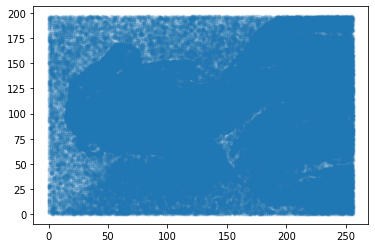

In [4]:
vector_density = grey.flatten()
vector_density = vector_density/torch.sum(vector_density)
lignes, colonnes = grey.shape
num_samples = 200000
cat = torch.distributions.Categorical(probs = vector_density)
categorical_samples = cat.sample([num_samples])
target_samples = torch.cat([(categorical_samples//colonnes).unsqueeze(-1), (categorical_samples%colonnes).unsqueeze(-1)], dim = -1) + torch.rand([num_samples,2])
plt.scatter(target_samples[:,0], target_samples[:, 1], alpha = .1, marker = '.')

In [5]:
num_samples = target_samples.shape[0]
epochs = 10
K = 100
initial_mu = torch.cartesian_prod(torch.linspace(0, lignes,10),torch.linspace(0, colonnes, 10))
initial_T = LocationScaleFlow(K, 2, initial_m = initial_mu, mode = 'full_rank')
EM = EMDensityEstimator(target_samples,K, initial_T = initial_T)
loss_values = EM.train(epochs,visual=True)

c:\users\ea264728\pycharmprojects\discretely-indexed-flows\venv\lib\site-packages\torch\functional.py:1069: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ..\aten\src\ATen\native\TensorShape.cpp:2157.)
  return _VF.cartesian_prod(tensors)  # type: ignore[attr-defined]
 10%|████████████▎                                                                                                              | 1/10 [00:05<00:50,  5.57s/it, loss = 10.732834815979004]


KeyboardInterrupt: 

In [ ]:
import pickle
filename = 'EM.sav'
pickle.dump(EM,open(filename,'wb'))

In [ ]:
EM = pickle.load(open('EM.sav', 'rb'))

In [ ]:
delta = 300
grid = torch.cartesian_prod(torch.linspace(-lignes/8, 1.125*lignes,2*lignes),torch.linspace(-colonnes/8, 1.125*colonnes, 2*colonnes))
density = torch.exp(EM.log_density(grid)).reshape(2*lignes,2*colonnes).T.cpu().detach()
fig = plt.figure(figsize =(10,10))
plt.imshow(torch.flip(torch.flip(density.T,[0,1]),[0,1]))

In [ ]:
from torch import nn
num_samples = target_samples.shape[0]
epochs = 100
batch_size = 20000
initial_T = EM.T
initial_w = SoftmaxWeightOver(K, 2, [10,10], mode = 'NN')
initial_w.f[-1].weight = nn.Parameter(torch.zeros(K, 10))
initial_w.f[-1].bias = nn.Parameter(EM.log_pi)
dif = DIFDensityEstimator(target_samples,K, initial_T= initial_T, initial_w = initial_w)
loss_values = dif.train(epochs,batch_size,visual=True)
dif.model_visual()

In [ ]:
delta = 300
grid = torch.cartesian_prod(torch.linspace(-lignes/8, 1.125*lignes,2*lignes),torch.linspace(-colonnes/8, 1.125*colonnes, 2*colonnes))
density = torch.exp(EM.log_density(grid)).reshape(2*lignes,2*colonnes).T.cpu().detach()
fig = plt.figure(figsize =(10,10))
plt.imshow(torch.flip(torch.flip(density.T,[0,1]),[0,1]))